<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number: 41
# Student 1: Nikhil Patni
# Student 2: Silvia Sultana
# Student 3: Aishvarya Viswanathan

In [3]:
import requests
import io
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Applicable only if you are building it on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [5]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [6]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    print(torch.tensor(queries[caseID]).shape)
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]
    print(torch.tensor(support_set[caseID,0]).shape)

    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])


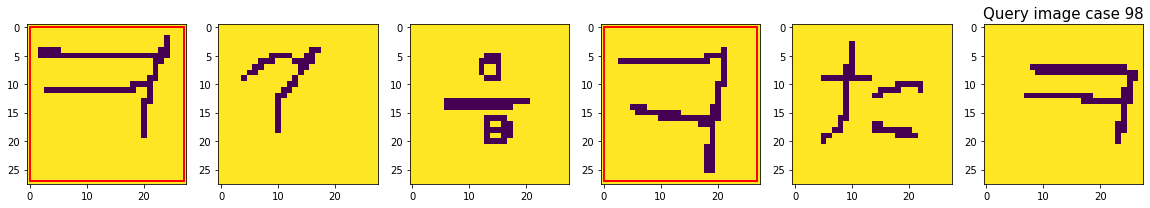

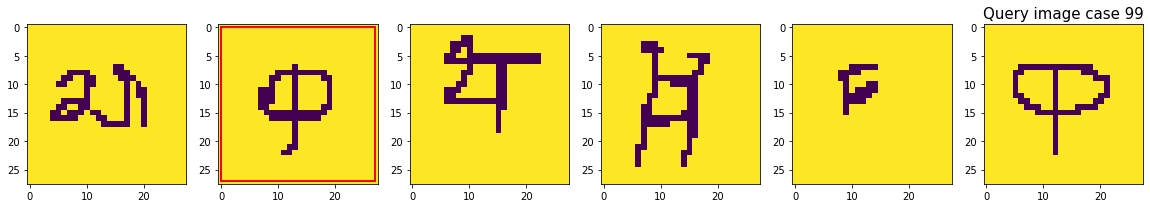

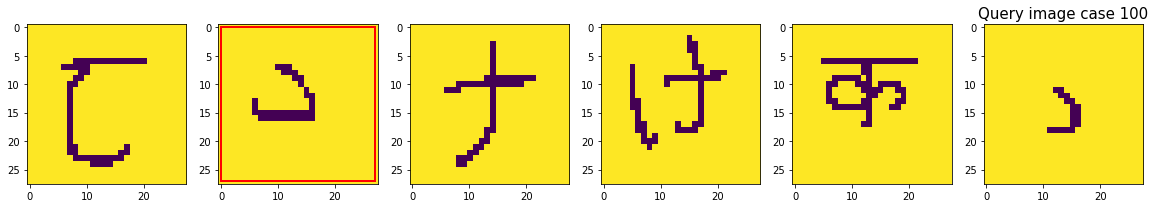

In [7]:
[plot_case(caseID,train_data,train_label) for caseID in range(98,101)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [8]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])


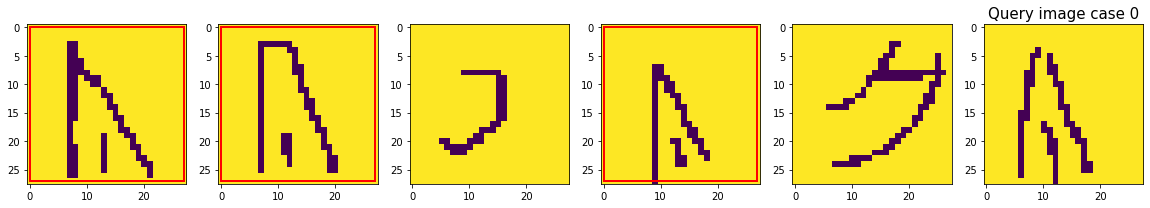

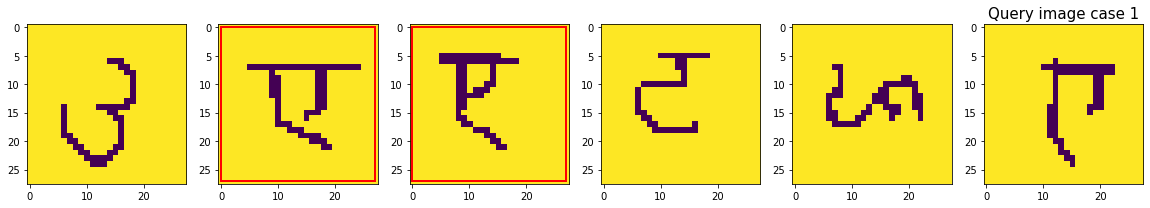

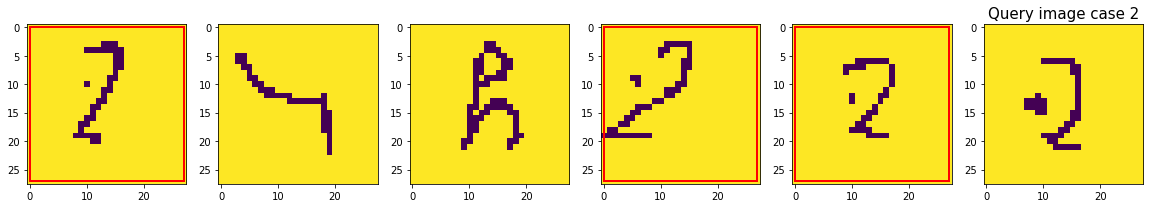

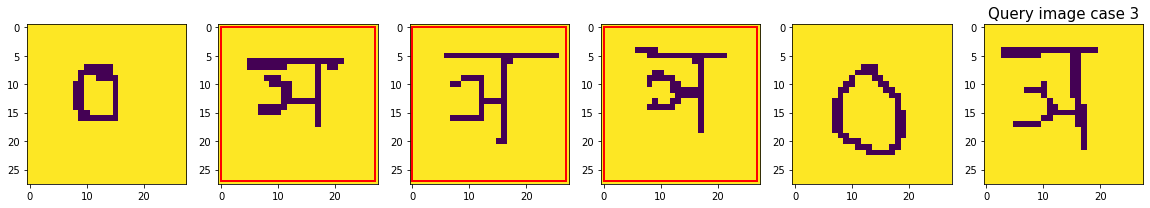

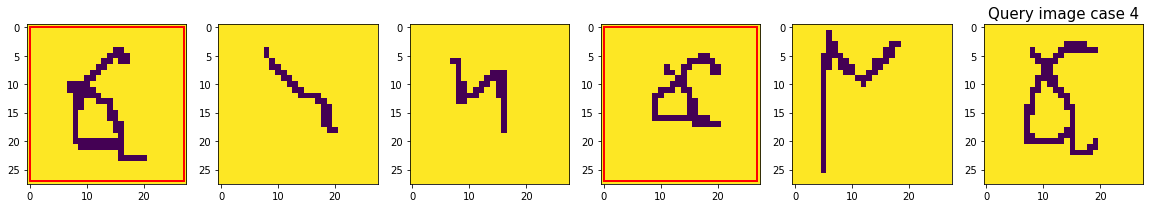

In [9]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [10]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [28]:
# transform = transforms.ToTensor()
train_dataset=MyDataset(train_data,train_label)
test_dataset=MyDataset(test_data,test_label)

In [32]:
print(train_dataset[:1])

(tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
         

In [69]:
# choose a training dataset size and further divide it into train and validation set 80:20
dataSize = 10000 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size

train_set, val_set = random_split(train_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=True)

In [13]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

In [47]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([1, 28, 28])
torch.Size([28, 28])


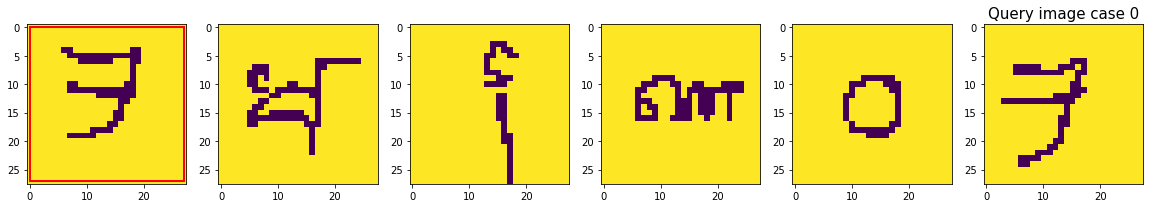

In [15]:
# showing a sample input of a training set
count0 = 0
count1 = 0
for img1, label in val_loader:
    if label[0][0] == 1.0:
      plot_case(0,img1,label)
        # print(img1[0])
        # plt.subplots(1, 6, figsize=(20,5))
        # plt.imshow(img1[0][0])
        #plt.subplot(1,2,2)
        #plt.imshow(img2[0][0])
        # print(label)
      break
    # break

In [16]:
#Different network structures, the commented out are the different experimenting structures
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 32, 3) 
        self.conv2 = nn.Conv2d(32, 64, 3)  
        self.conv3 = nn.Conv2d(64, 128, 3)
        #self.conv4 = nn.Conv2d(128, 256, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        #self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fcOut = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def convs(self, x):
        
        # out_dim = in_dim - kernel_size + 1
        # In = 1, 28,
        x = F.relu(self.bn1(self.conv1(x)))
        # Out = 32, 26, 26
        x = F.max_pool2d(x, (2,2))
        # Out = 32, 13, 13
        x = self.dropout2(x)
        x = F.relu(self.bn2(self.conv2(x)))
        # Out = 64, 11, 11
        x = F.max_pool2d(x, (2,2))
        # Out = 64, 5, 5
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout2(x)
        # Out = 128, 3, 3
        return x

    def forward(self, x1, x2):
        #breakpoint()
        x1 = self.convs(x1)

        x1 = x1.view(-1, 128 * 3 * 3)
        x1 = self.sigmoid(self.fc1(x1))
        # print("final x1",x1.shape)
        x2 = self.convs(x2)

        x2 = x2.view(-1, 128 * 3 * 3)
        x2 = self.sigmoid(self.fc1(x2))
        # print("final x2",x2.shape)
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        # print("final x",x.shape)
        # breakpoint()
        return x

In [17]:
#creating the original network and couting the paramenters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseNet = Net()
siameseNet = siameseNet.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(siameseNet)

The model architecture:

 Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fcOut): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 683,969 trainable parameters


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


In [18]:
# saving and loading checkpoint mechanisms
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'siameseNet-batchnorm50.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [19]:
trans = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Grayscale()
])

In [65]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, labels in train_loader:
            #plot_case(99,train_data,labels)
            support_set, queries = np.split(train_data, [5], axis=1)
            labels = torch.tensor_split(labels, 5, dim=1)
            # Forward
            case_loss = 0.0
            for x in range(5):
                img1 = queries.to(device)
                x2 = support_set[:,x]
                img2 = x2.view(-1,1,28,28).to(device)
                #print("support", x2.shape)
                #break
                #img2 = support_set.to(device)
                #labels = labels[:,[0][4]].view(-1,1).to(device)
                #print(labels[4].shape)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels[x].float().to(device))
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                case_loss += loss.item()

            case_loss = case_loss/5
            running_loss += case_loss

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, labels in val_loader:
                support_set, queries = np.split(val_data, [5], axis=1)
                labels = torch.tensor_split(labels, 5, dim=1)
                case_loss = 0.0
                for x in range(5):
                    img1 = queries.to(device)
                    #img2 = support_set.to(device)
                    x2 = support_set[:,x]
                    img2 = x2.view(-1,1,28,28).to(device)
                    #labels = labels[:,x].view(-1,1).to(device)
                    outputs = model(img1, img2)
                    #print("Outputs:",outputs)
                    #print("labels:",labels[x])
                    loss = criterion(outputs, labels[x].float().to(device))
                    case_loss += loss.item()

                case_loss = case_loss/5
                val_running_loss += case_loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  

# evaluation metrics
def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        for test_data, labels in test_loader:
            support_set, queries = np.split(test_data, [5], axis=1)
            queries = queries.to(device)
            #print(labels)
            predVal = 0
            pred = []
            for i in range(5):
                x2 = support_set[:,i]
                testImg = x2.view(-1,1,28,28).to(device)
                #print(testImg.shape)
                output = model(queries, testImg)
                #print(output)
                if output > 0:
                    pred.append(1)
                else:
                    pred.append(0)
            # print(labels[0])
            # print(torch.tensor(pred))
            if torch.eq(labels[0], torch.tensor(pred)).all():
                correct += 1
            count += 1
            if count % 100 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on 5 way 1-shot: {}'.format(correct/count))

In [70]:
# actual training
import torch.optim as optim

optimizer = optim.Adam(siameseNet.parameters(), lr = 0.0006)
num_epochs = 80
criterion = nn.BCEWithLogitsLoss()
save_path = 'siameseNet-batchnorm50.pt'
train_losses, val_losses = train(siameseNet, train_loader, val_loader, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/80],Train Loss: 0.0663, Valid Loss: 0.03161300
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 2
Epoch [2/80],Train Loss: 0.0640, Valid Loss: 0.03051967
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 3
Epoch [3/80],Train Loss: 0.0568, Valid Loss: 0.03254673
Starting epoch 4
Epoch [4/80],Train Loss: 0.0578, Valid Loss: 0.03153873
Starting epoch 5
Epoch [5/80],Train Loss: 0.0530, Valid Loss: 0.03210046
Starting epoch 6
Epoch [6/80],Train Loss: 0.0504, Valid Loss: 0.03194385
Starting epoch 7
Epoch [7/80],Train Loss: 0.0488, Valid Loss: 0.03117543
Starting epoch 8
Epoch [8/80],Train Loss: 0.0483, Valid Loss: 0.03255177
Starting epoch 9
Epoch [9/80],Train Loss: 0.0468, Valid Loss: 0.03196345
Starting epoch 10
Epoch [10/80],Train Loss: 0.0465, Valid Loss: 0.03223321
Starting epoch 11
Epoch [11/80],Train Loss: 0.0459, Valid Loss: 0.02977806
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 12
Epoch [12/80],Train Loss: 0.0420, Valid 

In [71]:
# Evaluation on previously saved models
import torch.optim as optim
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0006)


num_epochs = 10
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer)

print(best_val_loss)
eval(load_model, test_loader)

Model loaded from <== siameseNet-batchnorm50.pt
0.02977806323631739
Starting Iteration
Current Count is: 100
Accuracy on 5 way: 0.69
Current Count is: 200
Accuracy on 5 way: 0.71
Current Count is: 300
Accuracy on 5 way: 0.7066666666666667
Current Count is: 400
Accuracy on 5 way: 0.705
Current Count is: 500
Accuracy on 5 way: 0.714
Current Count is: 600
Accuracy on 5 way: 0.725
Current Count is: 700
Accuracy on 5 way: 0.7185714285714285
Current Count is: 800
Accuracy on 5 way: 0.72375
Current Count is: 900
Accuracy on 5 way: 0.7177777777777777
Current Count is: 1000
Accuracy on 5 way: 0.719


In [22]:
## Task  ##

In [23]:
## Model Definition ##

In [24]:
## LOSS Definition ##

In [25]:
## Build Sample Selector ##

In [26]:
## Training ##

In [27]:
## Evaluation ##